# Stats for the paper

```TODOs:```
- [x] For each system: average faithful, average gramm, average coverage
- [x] For each system: distribution over the merging categories (we’re mostly interested in the reference system)
- [x] For each MERGE CATEGORY: average faithful, average gramm (over all systems except reference)
  - Imbalanced concat: 90% faithful, 90% gramm
  - Replacement: 60% faithful, 95% gramm
  - Balanced concat: …
  - Other: …
- [x] Distribution over the merging categories (only on uncoverage summ sents -- consider a summ sent to be uncoverage if >= 51% of the responses were NO for coverage)
- [x] For each system: 3 summ sents that are unfaithful, 3 summ sents that are ungramm, 3 summ sents that are uncoverage


In [39]:
"""Gathers all statistics for paper and makes plots."""
import itertools

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

processed = pd.read_csv("processed.csv")
processed.set_index(["Answer.article_hash", "WorkerId"], inplace=True)

systems = ["bottom-up", "dca", "pg", "novel", "abs-rl-rerank", "reference"]
n_sys = len(systems)
n_exs = len(processed) * n_sys
eps = 1e-15

merge_d = {
    "Bal. Concat.": "bc",
    "Imbal. Concat.": "ic",
    "Replacement": "re",
    "Other": "ot",
}

sys_selec = [f"sys_{idx}" for idx in range(n_sys)]
grm_selec = [f"gramm_{idx}" for idx in range(n_sys)]
fth_selec = [f"faith_{idx}" for idx in range(n_sys)]
cvr_selec = [f"cover_{idx}" for idx in range(n_sys)]
mrg_selec = [f"merge_{idx}" for idx in range(n_sys)]
sum_selec = [f"summary_{idx}" for idx in range(n_sys)]
n_sys_sel = [f"n_{sys}" for sys in systems]

masks = {sys: (processed[sys_selec] == sys).values for sys in systems}
n_of = {sys: processed[f"n_{sys}"].sum() for sys in systems}

display(processed.head(n=1))
# display(processed.info())

,,n_bottom-up,n_reference,n_dca,n_pg,n_novel,n_abs-rl-rerank,sys_0,sys_1,sys_2,sys_3,...,summary_2,summary_3,summary_4,summary_5,sha_0,sha_1,sha_2,sha_3,sha_4,sha_5
Answer.article_hash,WorkerId,,,,,,,,,,,,,,,,,,,,,
ad7ae93a040c050c6264c5b1c55b6436503b34e406378689601c7dcc97f080e2,A1IZ4NX41GKU4X,0,1,3,1,1,0,dca,reference,pg,dca,...,guitar slinger jimi hendrix inflamed mainstrea...,the crowd at the american league game would be...,the american national anthem will be a nationa...,the late night of the gulf war in the san dieg...,919603c3c8e2217d9afe6e7a407d27d296363a71f451f1...,c6fa2649470d5bc264f3b9e5fc182f2918be95b1034d4a...,f0f10dd0a9be8230cd858590b3614a9717678b7e7b0b38...,a01be3c29e2edcc91106bed254a773e8bad56d3c790cb4...,3fa58b9761027bd14d20b5f2a88563b9dc07fe1c966b26...,98ad3008c98e52919d633781fc00ac0ac82946761b9985...


In [35]:
print(n_of)

{'bottom-up': 554, 'dca': 492, 'pg': 143, 'novel': 648, 'abs-rl-rerank': 58, 'reference': 379}


In [48]:
n_summs = processed.reset_index().iloc[0][n_sys_sel].copy()
n_summs[:] = 0
for _, group in processed.reset_index().groupby("Answer.article_hash"):
    n_summs += group.iloc[0][n_sys_sel]
    
n_summs

n_bottom-up        146
n_dca              130
n_pg                37
n_novel            171
n_abs-rl-rerank     16
n_reference        100
Name: 0, dtype: object

---
## Averages

### Tabular output

In [2]:
averages = pd.DataFrame(columns=["system", "gramm", "faith", "cover"])
averages["system"] = systems
averages.set_index(["system"], inplace=True)

for sys in systems:
    averages.loc[sys, "gramm"] = (processed[grm_selec] * masks[sys]).sum().sum() / n_of[sys]
    averages.loc[sys, "faith"] = (processed[fth_selec] * masks[sys]).sum().sum() / n_of[sys]
    averages.loc[sys, "cover"] = (processed[cvr_selec] * masks[sys]).sum().sum() / n_of[sys]
    
averages.reset_index(inplace=True)
averages

,system,gramm,faith,cover
0,bottom-up,0.788809,0.568592,0.785199
1,dca,0.723577,0.469512,0.626016
2,pg,0.846154,0.769231,0.895105
3,novel,0.785494,0.584877,0.753086
4,abs-rl-rerank,0.775862,0.689655,0.827586
5,reference,0.915567,0.883905,0.74934


### Graphical output

In [3]:
averages.sort_values(by=["faith"], inplace=True)
display(averages)
sns_averages = pd.melt(averages, id_vars=["system"], value_vars=["faith", "gramm", "cover"],
                       var_name="metric", value_name="probability")
display(sns_averages)

,system,gramm,faith,cover
1,dca,0.723577,0.469512,0.626016
0,bottom-up,0.788809,0.568592,0.785199
3,novel,0.785494,0.584877,0.753086
4,abs-rl-rerank,0.775862,0.689655,0.827586
2,pg,0.846154,0.769231,0.895105
5,reference,0.915567,0.883905,0.74934


,system,metric,probability
0,dca,faith,0.469512
1,bottom-up,faith,0.568592
2,novel,faith,0.584877
3,abs-rl-rerank,faith,0.689655
4,pg,faith,0.769231
5,reference,faith,0.883905
6,dca,gramm,0.723577
7,bottom-up,gramm,0.788809
8,novel,gramm,0.785494
9,abs-rl-rerank,gramm,0.775862


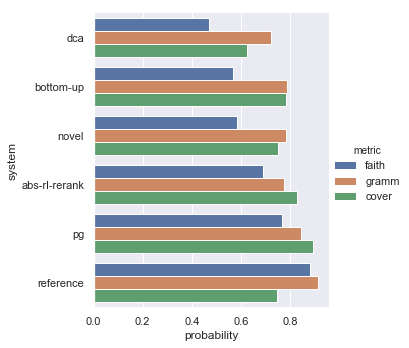

In [4]:
sns.set(style="darkgrid")
sns_averages_plot = sns.catplot(x="probability", y="system", hue="metric", data=sns_averages, kind="bar",)

sns_averages_plot.fig.savefig("averages.pdf")
sns_averages_plot

---
## Distribution over Merging

### Tabular output

In [5]:
merge_opts = list(merge_d.values())
merge_dist = pd.DataFrame(columns=["system"] + merge_opts)
merge_dist["system"] = systems
merge_dist.set_index(["system"], inplace=True)

# for sys, col in itertools.product(systems, merge_opts):
for sys, col in itertools.product(systems, merge_opts):
    merge_dist.loc[sys, col] = ((processed[mrg_selec] == col).values * masks[sys]).sum() / n_of[sys]

assert all(merge_dist.sum(axis=1) >= (1 - eps)), merge_dist.sum(axis=1)
merge_dist

,bc,ic,re,ot
system,,,,
bottom-up,0.315884,0.379061,0.111913,0.193141
dca,0.229675,0.365854,0.0934959,0.310976
pg,0.398601,0.405594,0.111888,0.0839161
novel,0.274691,0.382716,0.132716,0.209877
abs-rl-rerank,0.396552,0.344828,0.12069,0.137931
reference,0.313984,0.422164,0.0738786,0.189974


### Graphical output

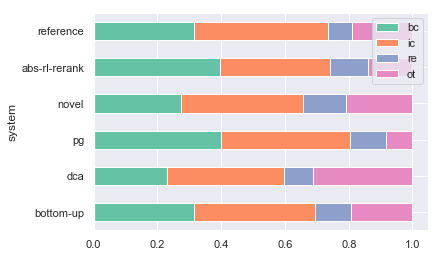

In [62]:
with sns.color_palette("Set2"):
    merge_dist_plot = merge_dist.plot(kind="barh", stacked=True)
    merge_dist_plot.figure.savefig("merge_dist.pdf")

---
## Averages over Merging

### Tabular output

In [7]:
avg_over_merge = pd.DataFrame(columns=["merge", "gramm", "faith", "cover", "prob"])
avg_over_merge["merge"] = merge_opts
avg_over_merge.set_index(["merge"], inplace=True)

G_mask = (processed[grm_selec] == True)
F_mask = (processed[fth_selec] == True)
C_mask = (processed[cvr_selec] == True)

p_gramm = G_mask.sum().sum() / n_exs  # p(grammatical)
p_faith = F_mask.sum().sum() / n_exs  # p(faithful)
p_cover = C_mask.sum().sum() / n_exs  # p(covered)

for opt in merge_opts:
    mrg_mask = (processed[mrg_selec] == opt).astype(int)
    avg_over_merge.loc[opt, "prob"] = mrg_mask.sum().sum() / n_exs
    
    avg_over_merge.loc[opt, "gramm"] = (G_mask.values * mrg_mask.values).sum() / mrg_mask.sum().sum()
    avg_over_merge.loc[opt, "faith"] = (F_mask.values * mrg_mask.values).sum() / mrg_mask.sum().sum()
    avg_over_merge.loc[opt, "cover"] = (C_mask.values * mrg_mask.values).sum() / mrg_mask.sum().sum()
    
assert (avg_over_merge["gramm"] * avg_over_merge["prob"]).sum() - p_gramm <= eps
assert (avg_over_merge["faith"] * avg_over_merge["prob"]).sum() - p_faith <= eps
assert (avg_over_merge["cover"] * avg_over_merge["prob"]).sum() - p_cover <= eps

avg_over_merge

,gramm,faith,cover,prob
merge,,,,
bc,0.869173,0.825564,0.944361,0.292436
ic,0.802511,0.694064,0.84589,0.385224
re,0.820408,0.530612,0.77551,0.10774
ot,0.682377,0.252049,0.270492,0.2146


### Graphical output

/Users/ionlights/.conda/envs/correctness-cpu/lib/python3.6/site-packages/seaborn/categorical.py:3692: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


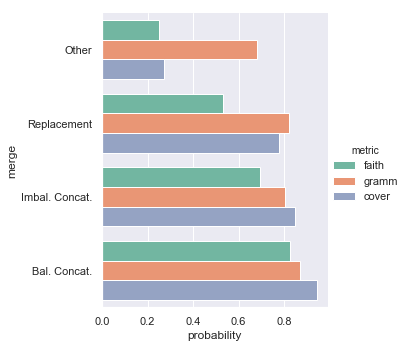

In [77]:
avg_over_merge_plot = avg_over_merge.drop(columns=["prob"]).reset_index().sort_values(by=["faith"])
avg_over_merge_plot = pd.melt(avg_over_merge_plot, id_vars=["merge"], value_vars=["faith", "gramm", "cover"],
                              var_name="metric", value_name="probability")
rev_merge_d = {v: k for k, v in merge_d.items()}
avg_over_merge_plot["merge"] = avg_over_merge_plot["merge"].map(rev_merge_d)

with sns.color_palette("Set2"):
    sns_avg_over_merge_plot = sns.catplot(x="probability", y="merge", hue="metric",
                                          data=avg_over_merge_plot, size=5, kind="bar")
    sns_avg_over_merge_plot.fig.savefig("avg_over_merge.pdf")
    sns_avg_over_merge_plot

---
## Distribution over Merging for `[unfaithful, ungrammatical, uncoverage]`

### Tabular output

In [9]:
# Distribution over the merging categories (only on uncoverage summ sents -- consider a summ sent to be 
# uncoverage if >= 51% of the responses were NO for coverage)
idx_mask = np.arange(start=1, stop=n_sys + 1)
def merge_dist_for(cols: list):
    df = pd.DataFrame(columns=["merge"])
    df["merge"] = merge_opts
    df.set_index(["merge"], inplace=True)
    df["count"] = 0
    df["total"] = [(processed[mrg_selec] == opt).sum().sum() for opt in merge_opts]
    df["percent"] = 0.
    
    mask = np.empty_like(processed[sys_selec])
    idx = 0
    for article, responses in processed.groupby("Answer.article_hash"):
        un_cols = ((1 - responses[cols].mean().values) > 0.5) * idx_mask - 1
        
        off = responses.shape[0]
        mask[idx:(idx + off)] = np.tile(un_cols, reps=off).reshape(off, n_sys)
        idx += off
        
        selects = [v for v in un_cols if v > -1]
        df_sele = responses.iloc[0][mrg_selec].values[selects]
        df.loc[df_sele, "count"] += 1
        
    df["percent"] = df["count"] / df["total"]
        
    return df, mask

from IPython.display import Markdown

display(Markdown("### Unfaithful"))
merge_dist_unfaith, mask_unfaith = merge_dist_for(fth_selec)
display(merge_dist_unfaith)

display(Markdown("### Ungrammatical"))
merge_dist_ungramm, mask_ungramm = merge_dist_for(grm_selec)
display(merge_dist_ungramm)

display(Markdown("### Uncoverage"))
merge_dist_uncover, mask_uncover = merge_dist_for(cvr_selec)
display(merge_dist_uncover)

### Unfaithful

,count,total,percent
merge,,,
bc,20,665,0.030075
ic,42,876,0.047945
re,19,245,0.077551
ot,39,488,0.079918


### Ungrammatical

,count,total,percent
merge,,,
bc,11,665,0.016541
ic,17,876,0.019406
re,5,245,0.020408
ot,16,488,0.032787


### Uncoverage

,count,total,percent
merge,,,
bc,8,665,0.012030
ic,16,876,0.018265
re,6,245,0.024490
ot,27,488,0.055328


### Graphical output

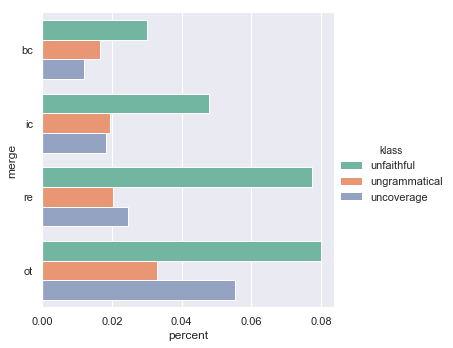

In [59]:
merge_dist_uns = pd.DataFrame(columns=["merge", "klass", "percent"])
merge_dist_uns["merge"] = merge_opts * 3
merge_dist_uns["klass"] = ["unfaithful"] * 4 + ["ungrammatical"] * 4 + ["uncoverage"] * 4
percents = list(merge_dist_unfaith["percent"]) + list(merge_dist_ungramm["percent"]) + list(merge_dist_uncover["percent"])
merge_dist_uns["percent"] = percents

# merge_dist_unfaith.plot(kind="barh", y="percent")
# merge_dist_uncover.plot(kind="barh", y="percent")
# merge_dist_ungramm.plot(kind="barh", y="percent")

with sns.color_palette("Set2"):
    sns_merge_dist_uns = sns.catplot(kind="bar", y="merge", x="percent", hue="klass", data=merge_dist_uns)
    sns_merge_dist_uns.fig.savefig("merge_dist_uns.pdf")

---
## 3 Examples (per system) of `[unfaithful, ungrammatical, uncoverage]`

In [78]:
# TODO: rework to be able to select out exact examples
from IPython.display import HTML

np.random.seed(42)

def sample_un_exs(sys: str, n: int = 3):
    display(Markdown(f"---\n## {sys}"))
    for name, uncat in zip(["unfaithful", "ungrammatical", "uncoverage"],
                           [mask_unfaith, mask_ungramm, mask_uncover]):
        display(Markdown(f"### {name}"))
        
        mask = (processed[sum_selec] * (uncat > 0) * masks[sys]).values
        uniq = np.unique(mask.flatten())[1:]  # remove empty string
        
        try:
            summaries = np.random.choice(uniq, size=n, replace=False)
        except ValueError:
            summaries = np.random.choice(uniq, size=n - 1, replace=False):

        for summ in summaries:
            display(HTML(summ))

for sys in systems:
    sample_un_exs(sys)

---
## bottom-up

### unfaithful

### ungrammatical

### uncoverage

---
## dca

### unfaithful

### ungrammatical

### uncoverage

---
## pg

### unfaithful

### ungrammatical

### uncoverage

---
## novel

### unfaithful

### ungrammatical

### uncoverage

---
## abs-rl-rerank

### unfaithful

### ungrammatical

ValueError: Cannot take a larger sample than population when 'replace=False'

---
## Average System Summary Length

In [12]:
sys_summ_len = pd.DataFrame(columns=["sys", "avg_len"])
sys_summ_len["sys"] = systems
sys_summ_len.set_index(["sys"], inplace=True)

for sys in systems:
    mask = (masks[sys] * (processed[sum_selec])).values
    mask = np.unique(mask.flatten())[1:]
    lens = sum([len(x) for x in mask])
    sys_summ_len.loc[sys, "avg_len"] = lens / mask.shape[0]
    
sys_summ_len

,avg_len
sys,
bottom-up,74.9315
dca,81.5154
pg,110.595
novel,86.1404
abs-rl-rerank,73.8125
reference,76.14


---
# Fleiss' Kappa

In [33]:
from nltk.metrics.agreement import AnnotationTask

def fleiss_kappa(col: list, name: str):
    display(Markdown(f"**{name}**"))
    annots = processed.reset_index()[["Answer.article_hash", "WorkerId",] + col]
    annots = pd.melt(annots, id_vars=["Answer.article_hash", "WorkerId"],
                     value_vars=col, value_name="label", var_name="task")

    kappas = []
    for article, group in annots.groupby("Answer.article_hash"):
        coder = list(group["WorkerId"])
        label = list(group["label"])
        item  = list(group[["Answer.article_hash", "task"]].apply(lambda x: "".join(x), axis=1))

        try:
            fleiss = AnnotationTask([x for x in zip(coder, item, label)])
            kappas.append(fleiss.multi_kappa())
        except ZeroDivisionError:
            print(article)
            continue

    kappas = np.array(kappas)
    display(f"max  : {kappas.max()}")
    display(f"mean : {kappas.mean()}")
    display(f"stdev: {kappas.std()}")
    display(f"min  : {kappas.min()}")
    
    f, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
    display(sns.distplot(kappas, ax=axes[0]))
    display(sns.distplot(kappas, bins=20, kde=False, ax=axes[1]))
    plt.show()

**Faithfulness**

99bfa29e7b1591fd3de14fbc3295800109623f9dc6abebd7f0cf3203cc61b044


'max  : 0.7272727272727274'

'mean : 0.10179360462124823'

'stdev: 0.19143578909321426'

'min  : -0.33333333333333337'

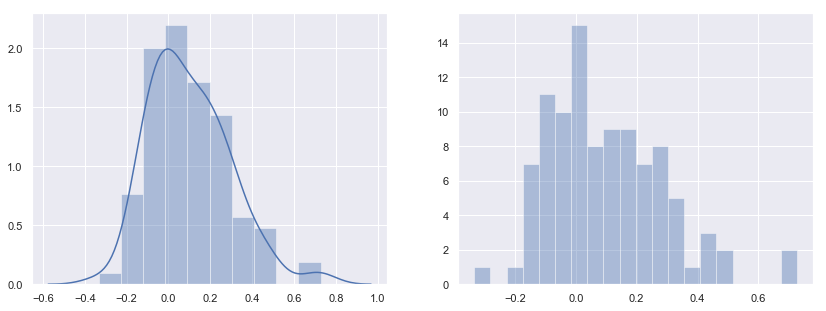

**Grammaticality**

39bc958bd11a0bb2abff646b858b577ae8a33cbff471f0f78b6dad63b5889bfa
4ee1a47c46b42bc23a5727804c7275b94421408f0aeb6ca1d18fdcbd302b3e20
5df775673ca8c2a5a3392233a1a6007a7d08bfcc7bacfc4a61fffd52b86556fd
79e5c3f681b4dd272f3467d86399dae17a57973b465e9b33e8e48a7734898b1e
bbacac2968afef9583d767225d1faf928d1f10ecac8dad1a090c77db730d2e94


'max  : 0.7272727272727274'

'mean : 0.0749945209268485'

'stdev: 0.19228988061495625'

'min  : -0.30434782608695654'

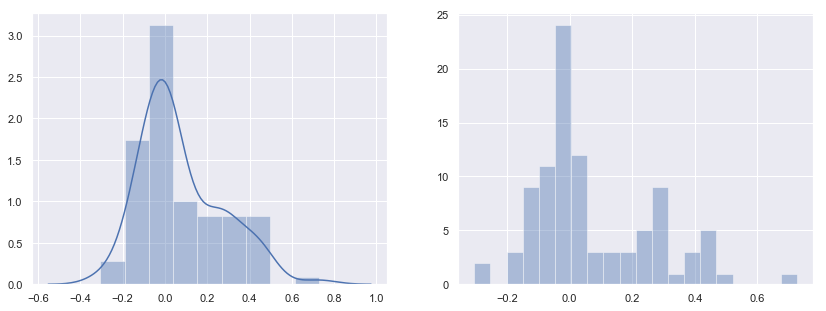

**Merging**

'max  : 0.2758620689655171'

'mean : 0.022722050974455968'

'stdev: 0.095333752318243'

'min  : -0.1851851851851852'

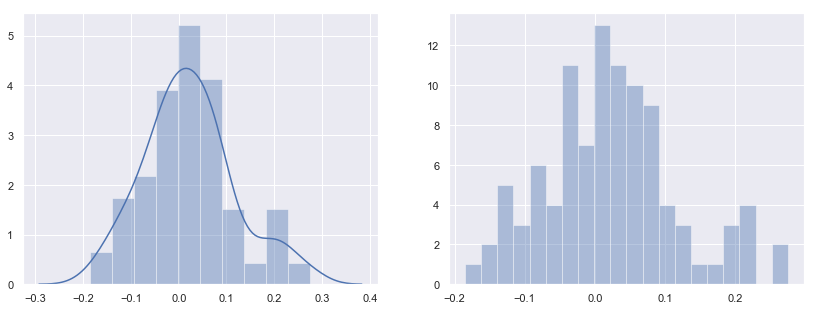

In [34]:
fleiss_kappa(fth_selec, "Faithfulness")
fleiss_kappa(grm_selec, "Grammaticality")
fleiss_kappa(mrg_selec, "Merging")